# A two-sector I-HANK model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Steady state](#toc2_)    
- 3. [Compute Jacobians](#toc3_)    
- 4. [Foreign demand shock](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from IHANKModel import IHANKModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = IHANKModelClass(name='baseline')

In [3]:
model.info()

settings:
 par.py_hh = True
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [ra,inc_T,inc_NT]
 inputs_hh_z: []
 outputs_hh: [a,c,uc_T,uc_NT]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [ZT,ZNT,M_s,rF,PF_s]
 unknowns: [E,NNT,NT,piWT,piWNT]
 targets: [NKWCT_res,NKWCNT_res,clearing_YT,clearing_YNT,UIP_res]

blocks (inputs -> outputs):
 production: [ZT,ZNT,NT,NNT,piWT,piWNT] -> [YT,YNT,WT,WNT,PTH,PNT]
 prices: [PF_s,E,PTH,PNT,WT,WNT] -> [PF,PTH_s,PT,P,Q,wT,wNT]
 inflation: [PF_s,PF,PNT,PTH,PT,P,PTH_s] -> [pi_F_s,pi_F,pi_NT,pi_TH,pi_T,pi,pi_TH_s]
 central_bank: [pi] -> [i,r,ra]
 government: [PNT,P,wT,NT,wNT,NNT,ra] -> [G,B,tau,inc_T,inc_NT]
 hh: [inc_NT,inc_T,ra] -> [A_hh,C_hh,UC_T_hh,UC_NT_hh]
 NKWCs: [piWT,piWNT,NT,NNT,wT,wNT,tau,UC_T_hh,UC_NT_hh] -> [NKWCT_res,NKWCNT_res]
 UIP: [Q,r,rF] -> [UIP_res]
 consumption: [C_hh,PT,PNT,P,PTH,PF,M_s,PTH_s,PF_s] -> [CT,CNT,CTF,CTH,CTH_s]
 market_clearing: [YT,C

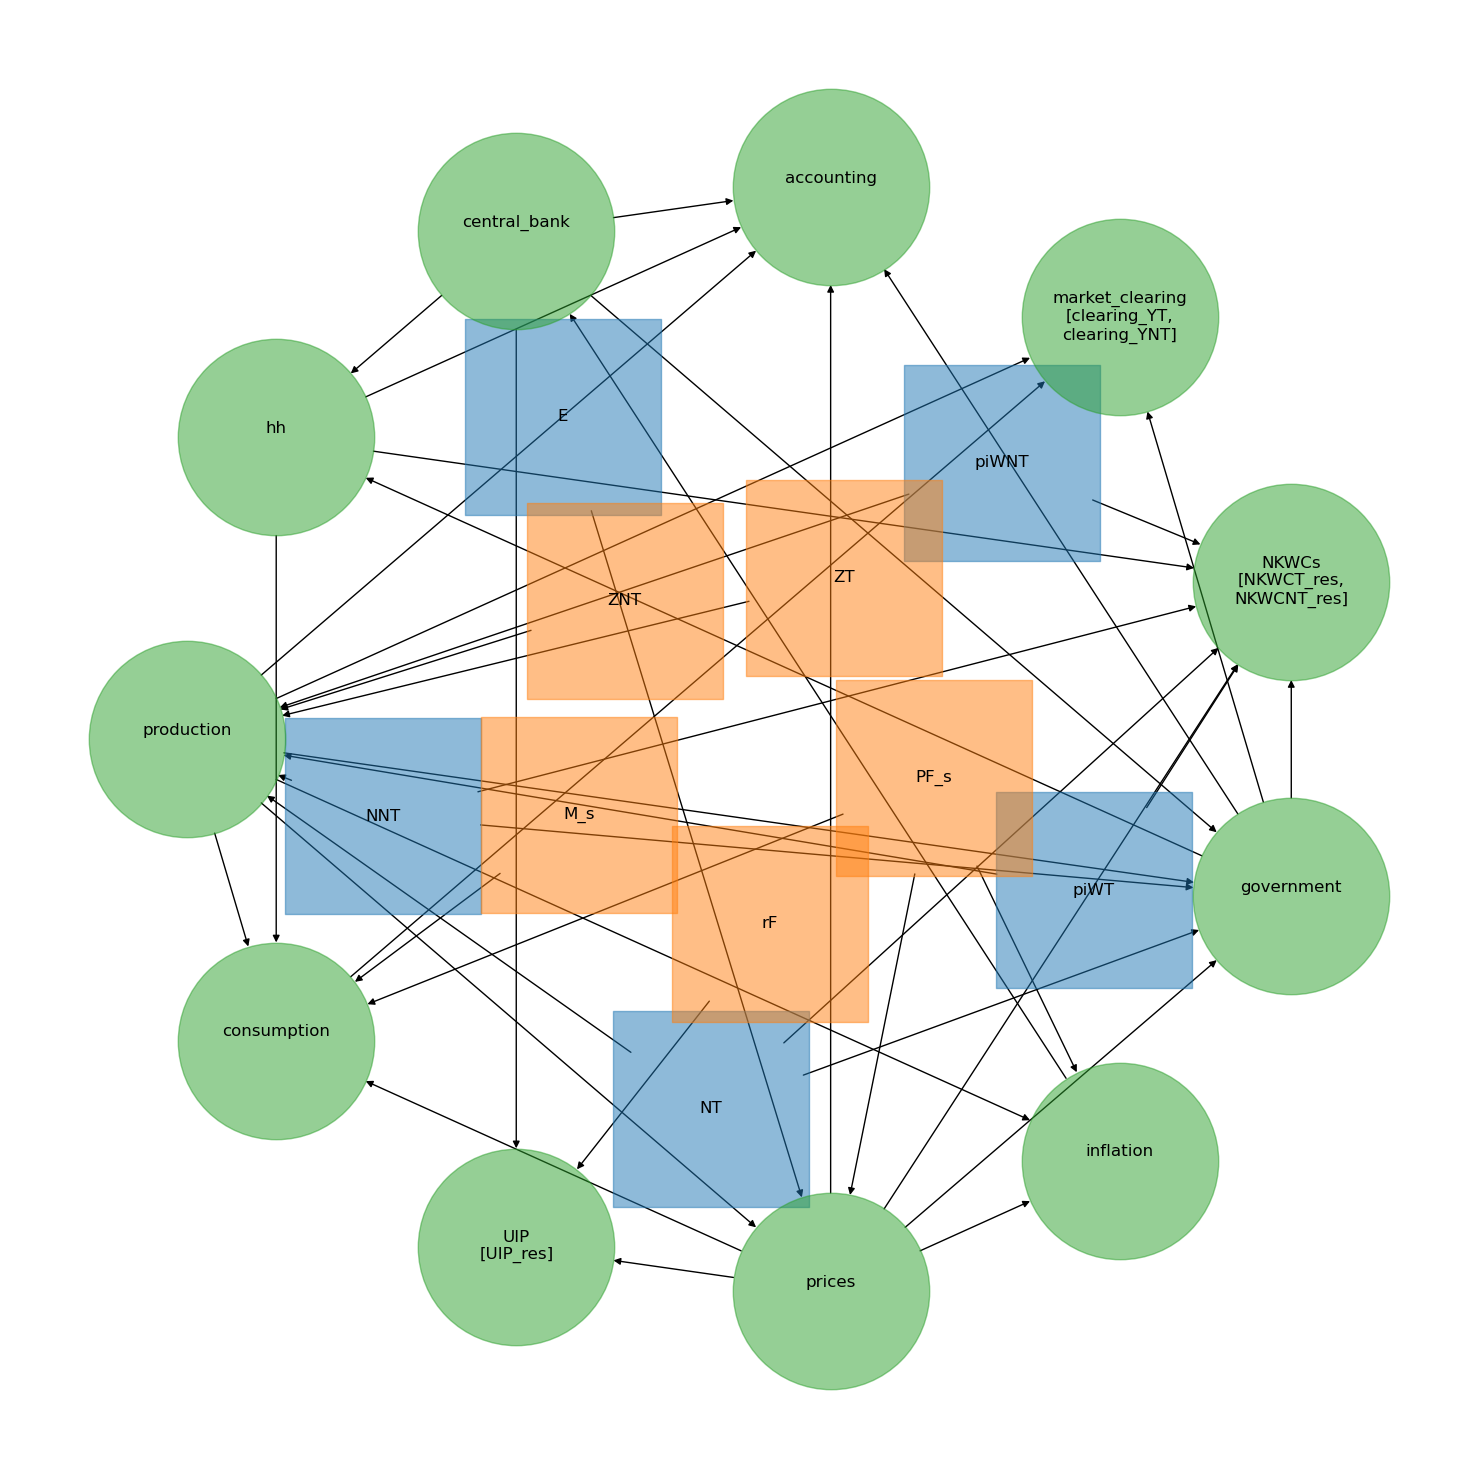

In [4]:
model.draw_DAG(figsize=(15,15),order=['shocks','unknowns','blocks'])

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## 2. <a id='toc2_'></a>[Steady state](#toc0_)

In [6]:
model.find_ss(do_print=True)

household problem in ss solved in 0.9 secs [375 iterations]
household problem in ss simulated in 5.6 secs [419 iterations]
steady state found in 7.5 secs
ss.inc_T = 0.700
ss.inc_NT = 0.700
par.alphaT = 0.355
par.alphaF = 0.333
par.varphiT = 1.271
par.varphiNT = 1.271
ss.M_s = 0.083
ss.clearing_YT =   0.00000000
ss.clearing_YNT =   0.00000000
ss.G = 0.296
ss.NFA = 0.000


In [7]:
model.test_ss()

ZT             :       1.0000
ZNT            :       1.0000
NT             :       0.2500
NNT            :       0.7500
piWT           :       0.0000
piWNT          :       0.0000
YT             :       0.2500
YNT            :       0.7500
WT             :       1.0000
WNT            :       1.0000
PTH            :       1.0000
PNT            :       1.0000
PF_s           :       1.0000
E              :       1.0000
PF             :       1.0000
PTH_s          :       1.0000
PT             :       1.0000
P              :       1.0000
Q              :       1.0000
wT             :       1.0000
wNT            :       1.0000
pi_F_s         :       0.0000
pi_F           :       0.0000
pi_NT          :       0.0000
pi_TH          :       0.0000
pi_T           :       0.0000
pi             :       0.0000
pi_TH_s        :       0.0000
i              :       0.0050
r              :       0.0050
ra             :       0.0050
G              :       0.2963
B              :       0.7483
tau       

In [8]:
MPC = np.sum(ss.D[:,:,:-1]*(ss.c[:,:,1:]-ss.c[:,:,:-1])/((1+ss.r)*(par.a_grid[1:]-par.a_grid[:-1])))
print(f'{MPC:.2f}')

0.32


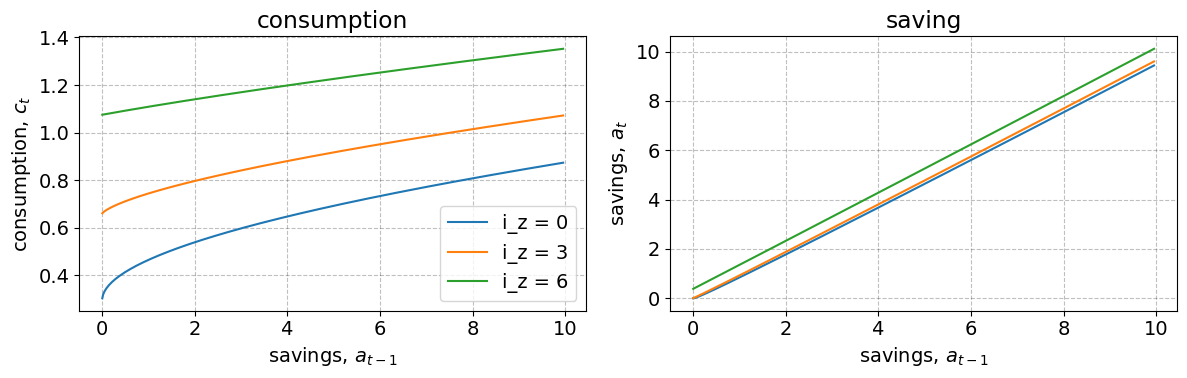

In [9]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 10

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

fig.tight_layout()

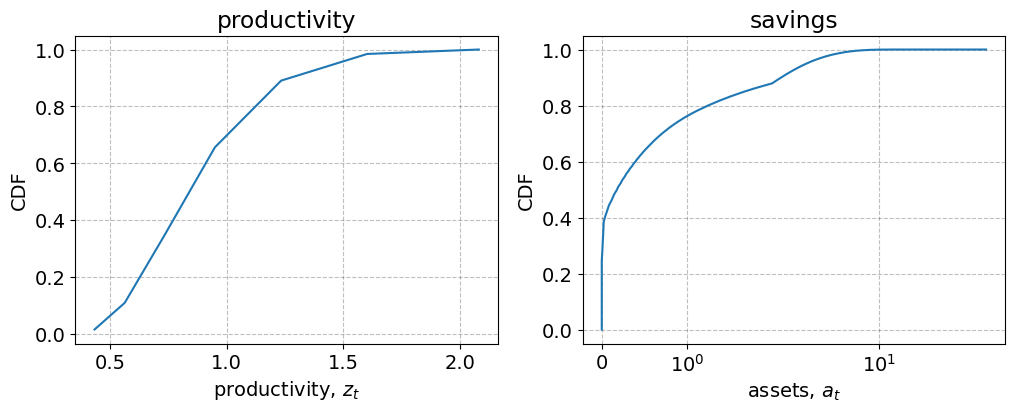

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 3. <a id='toc3_'></a>[Compute Jacobians](#toc0_)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.4 secs
household problem simulated along transition in 2.8 secs



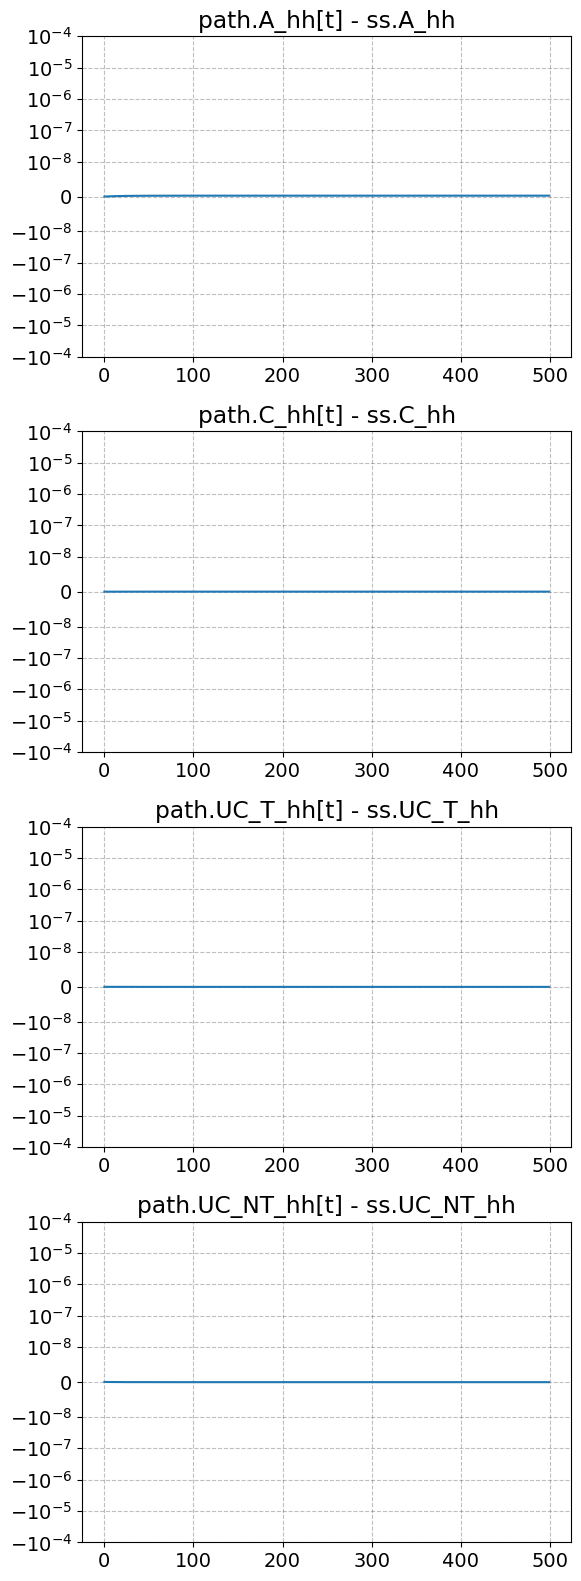

In [11]:
model.test_hh_path()

**Full transition path:**

In [12]:
model.test_path()

shocks: ZT ZNT M_s rF PF_s 
unknowns: E NNT NT piWT piWNT 

blocks.production
 YT               0.0e+00
 YNT              0.0e+00
 WT               0.0e+00
 WNT              0.0e+00
 PTH              0.0e+00
 PNT              0.0e+00
blocks.prices
 PF               0.0e+00
 PTH_s            0.0e+00
 PT               0.0e+00
 P                0.0e+00
 Q                0.0e+00
 wT               0.0e+00
 wNT              0.0e+00
blocks.inflation
 pi_F_s           0.0e+00
 pi_F             0.0e+00
 pi_NT            0.0e+00
 pi_TH            0.0e+00
 pi_T             0.0e+00
 pi               0.0e+00
 pi_TH_s          0.0e+00
blocks.central_bank
 i                0.0e+00
 r                1.1e-16
 ra               1.1e-16
blocks.government
 G                0.0e+00
 B                5.6e-16
 tau              5.6e-17
 inc_T            1.1e-16
 inc_NT           2.2e-16
hh
 A_hh             2.5e-10
 C_hh             1.5e-11
 UC_T_hh          2.0e-11
 UC_NT_hh         5.9e-11
blocks.NKWCs
 NKWC

**Jacobians:**

In [13]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for inc_NT          in 2.0 secs
curly_Y and curly_D calculated for inc_T           in 2.1 secs
curly_Y and curly_D calculated for ra              in 1.8 secs
curly_E calculated in 5.0 secs
builiding blocks combined in 1.6 secs
household Jacobian computed in 12.5 secs

full Jacobians:
full Jacobian to unknowns computed in 5.8 secs [in evaluate_blocks(): 2.1 secs]
full Jacobian to shocks computed in 7.6 secs [in evaluate_blocks(): 2.6 secs]


## 4. <a id='toc4_'></a>[Foreign demand shock](#toc0_)

In [14]:
par.jump_M_s = -0.01 # initial jump
par.rho_M_s = 0.80 # AR(1) coefficeint

par.jump_rF = -0.0001 # initial jump
par.rho_rF = 0.80 # AR(1) coefficeint

par.jump_PF_s = -0.0025 # initial jump
par.rho_PF_s = 0.80 # AR(1) coefficeint

model.find_transition_path(shocks=['M_s','rF','PF_s'],do_print=True,do_end_check=False)

finding the transition path:
 it =   0 -> max. abs. error = 1.05e-02
   1.05e-05 in NKWCT_res
   1.05e-05 in NKWCNT_res
   1.05e-02 in clearing_YT
   2.30e-04 in clearing_YNT
   3.14e-04 in UIP_res
 it =   1 -> max. abs. error = 4.08e-04
   1.78e-04 in NKWCT_res
   7.66e-06 in NKWCNT_res
   3.82e-04 in clearing_YT
   6.40e-05 in clearing_YNT
   4.08e-04 in UIP_res
 it =   2 -> max. abs. error = 4.22e-05
   1.67e-05 in NKWCT_res
   4.91e-07 in NKWCNT_res
   1.53e-05 in clearing_YT
   6.36e-06 in clearing_YNT
   4.22e-05 in UIP_res
 it =   3 -> max. abs. error = 1.03e-06
   1.03e-06 in NKWCT_res
   2.46e-08 in NKWCNT_res
   4.65e-07 in clearing_YT
   4.15e-07 in clearing_YNT
   3.86e-07 in UIP_res
 it =   4 -> max. abs. error = 2.12e-08
   7.31e-09 in NKWCT_res
   2.79e-10 in NKWCNT_res
   1.15e-08 in clearing_YT
   2.73e-09 in clearing_YNT
   2.12e-08 in UIP_res
 it =   5 -> max. abs. error = 5.32e-10
   5.32e-10 in NKWCT_res
   9.81e-12 in NKWCNT_res
   4.27e-10 in clearing_YT
   1.43e

### shocks ###


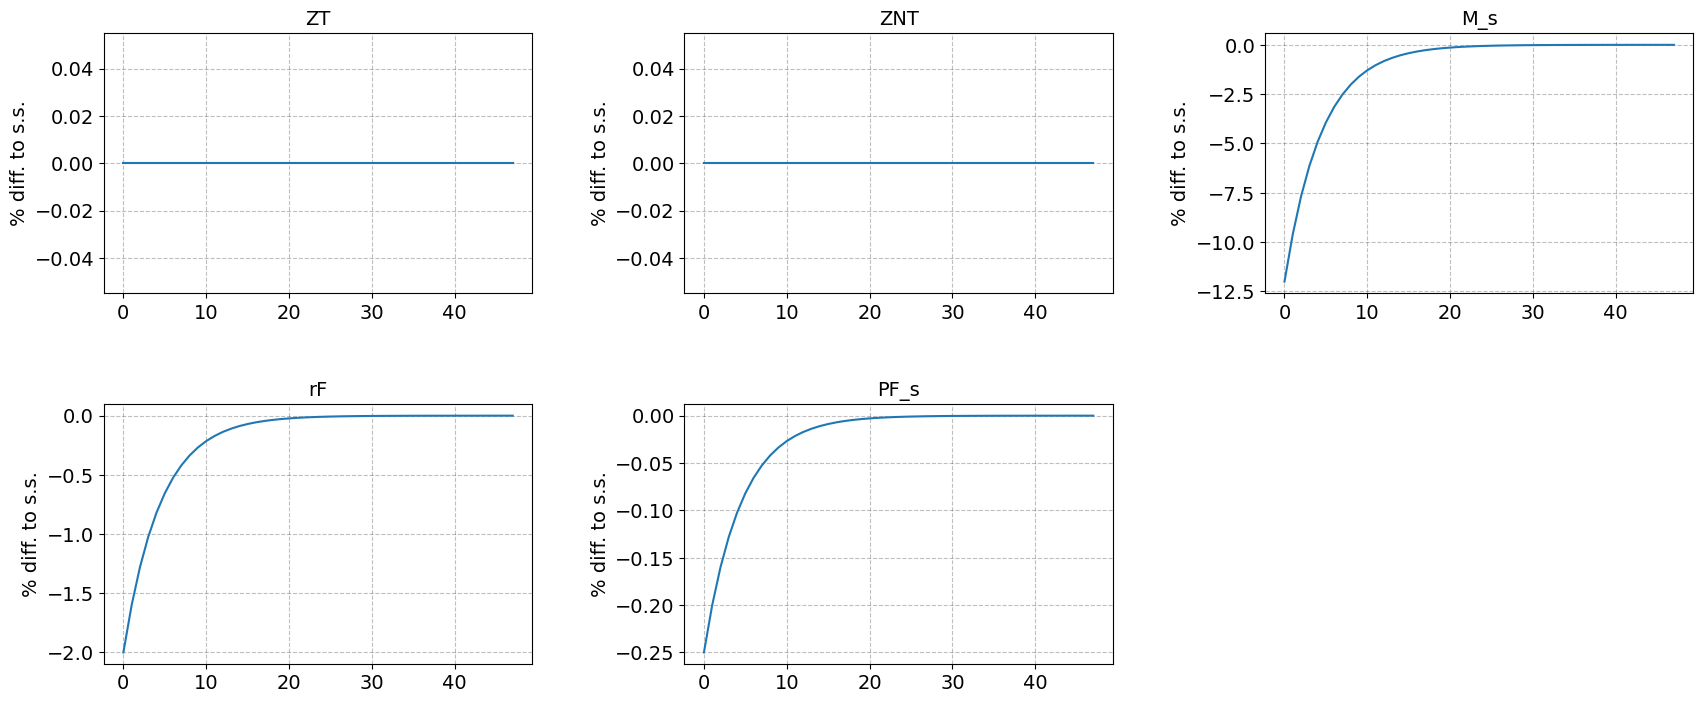


### varnames ###


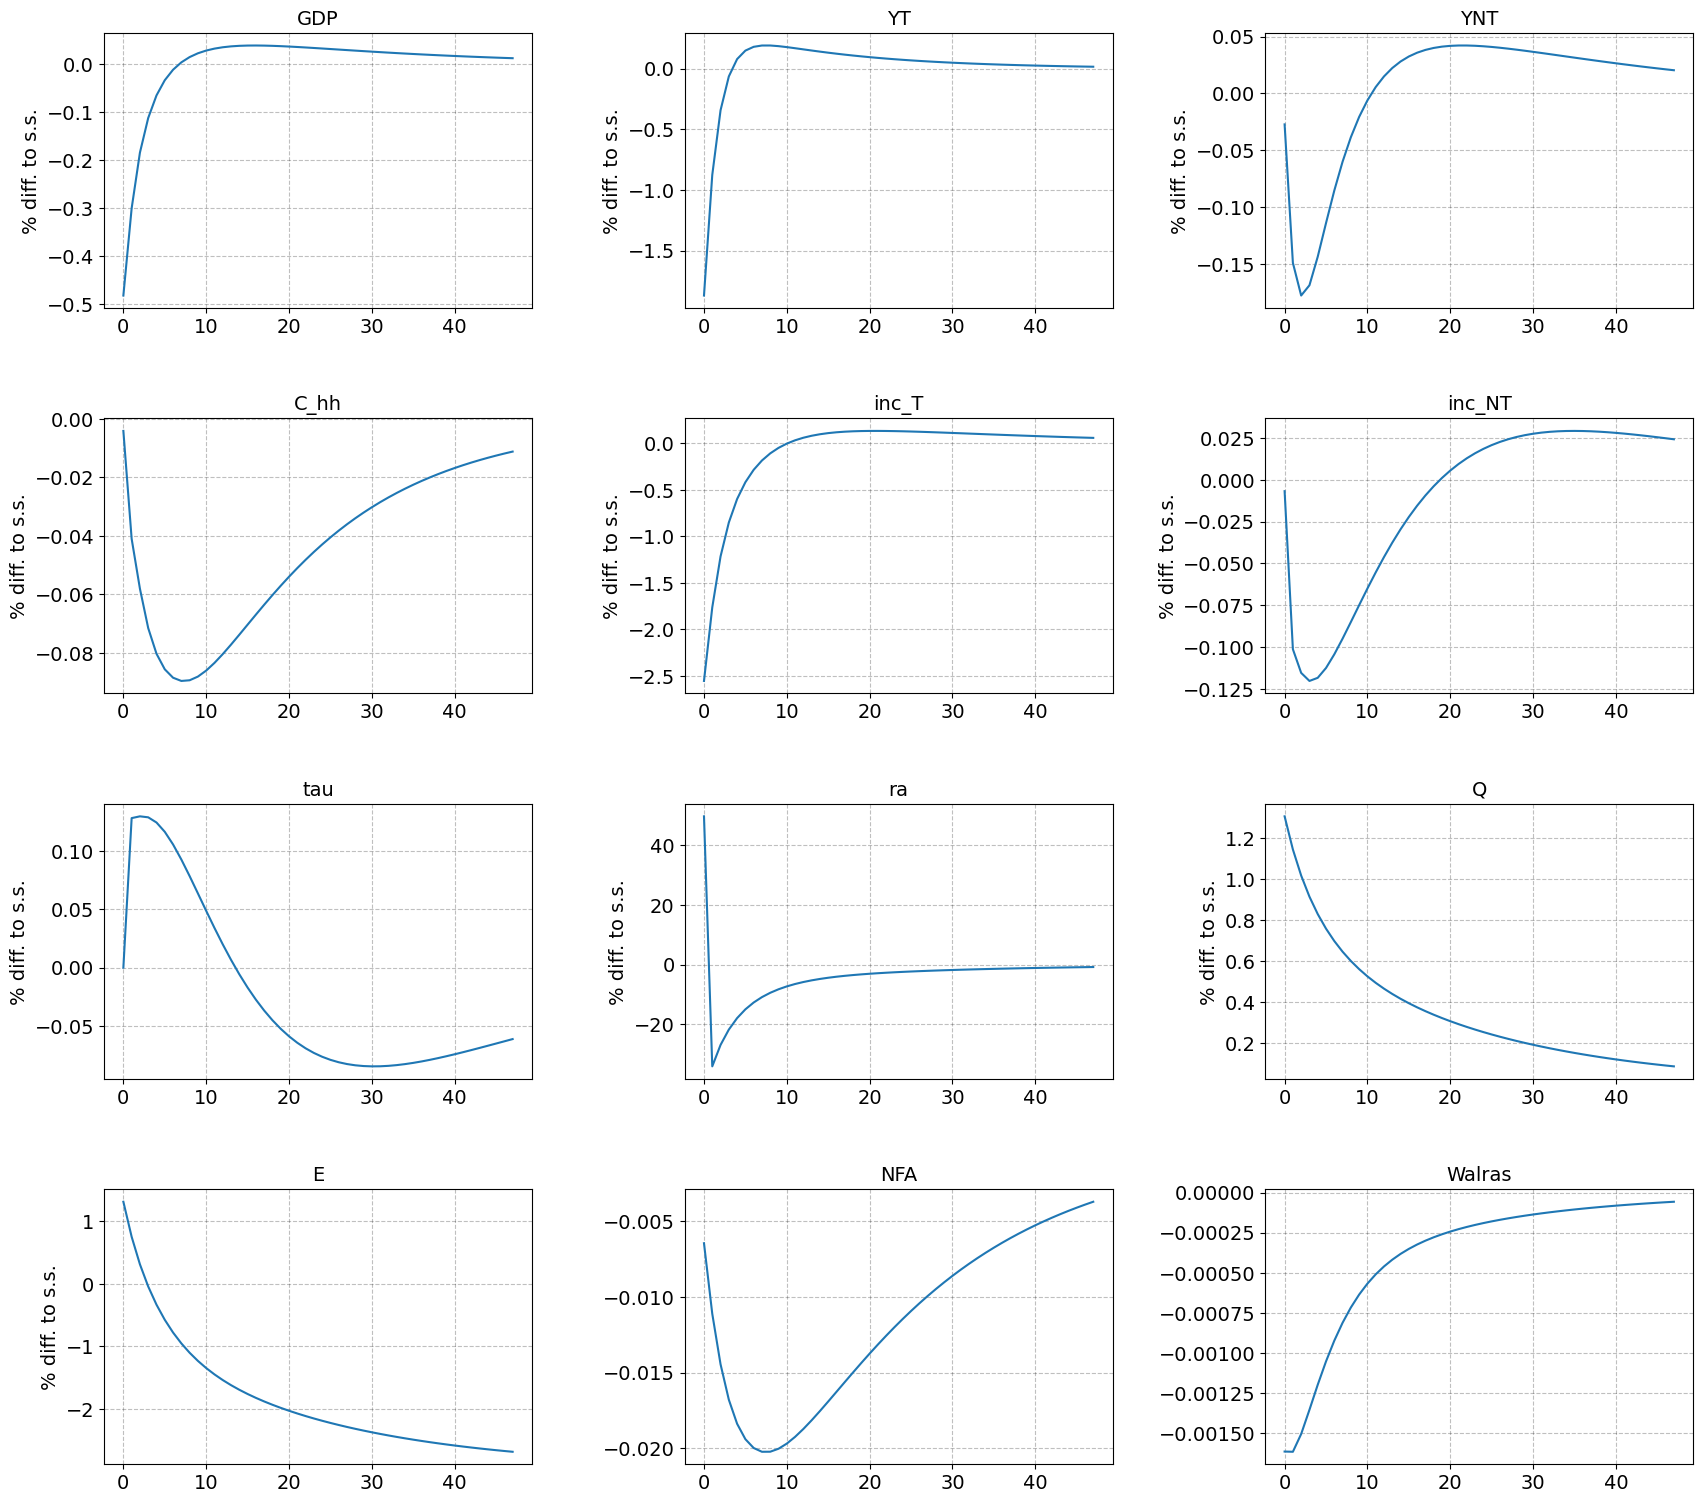


### tagets ###


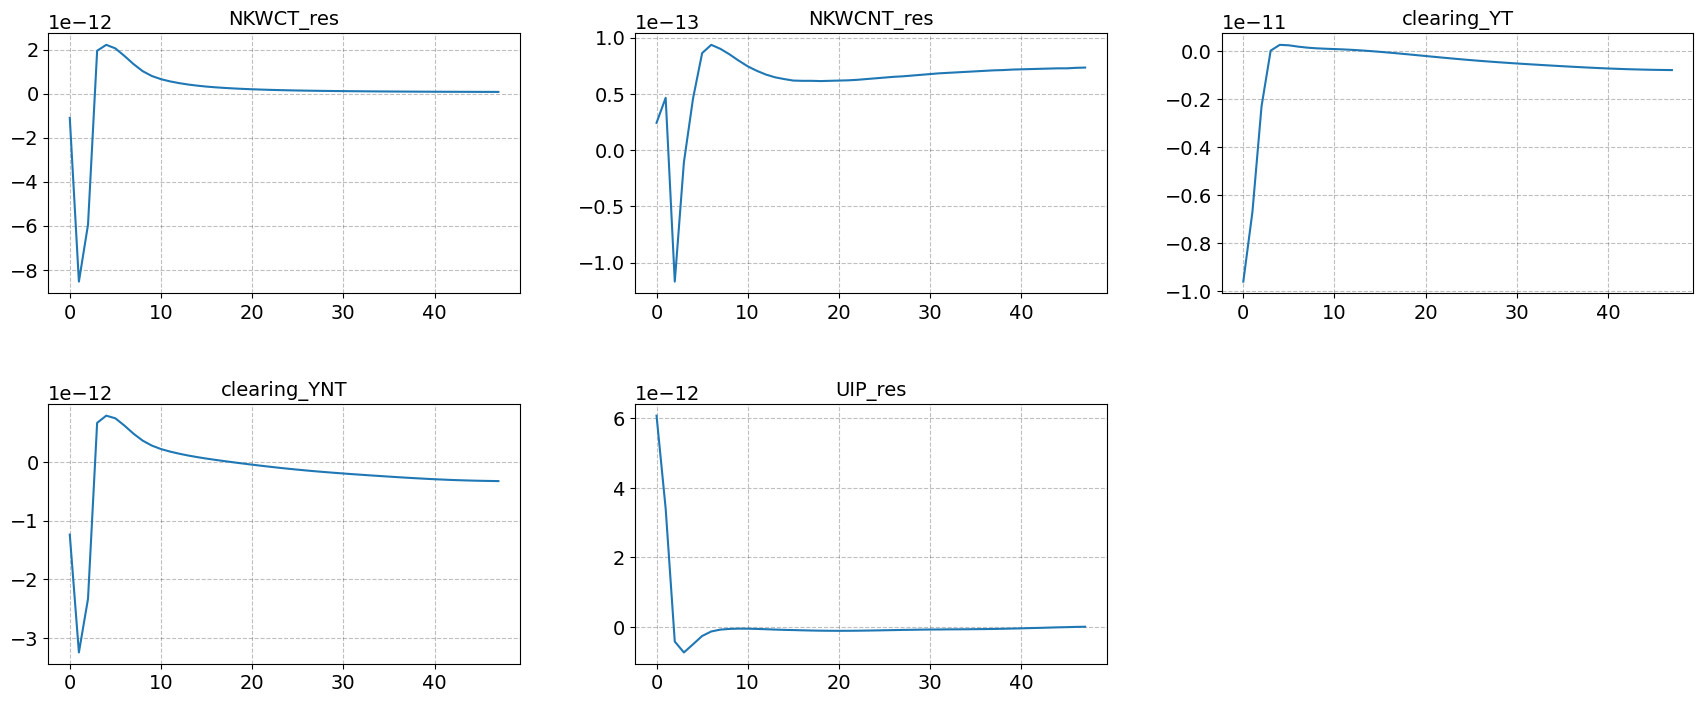

In [15]:
paths = ['GDP','YT','YNT','C_hh','inc_T','inc_NT','tau','ra','Q','E','NFA','Walras']
lvl_value=['r','NFA','Walras']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=48,ncols=3)

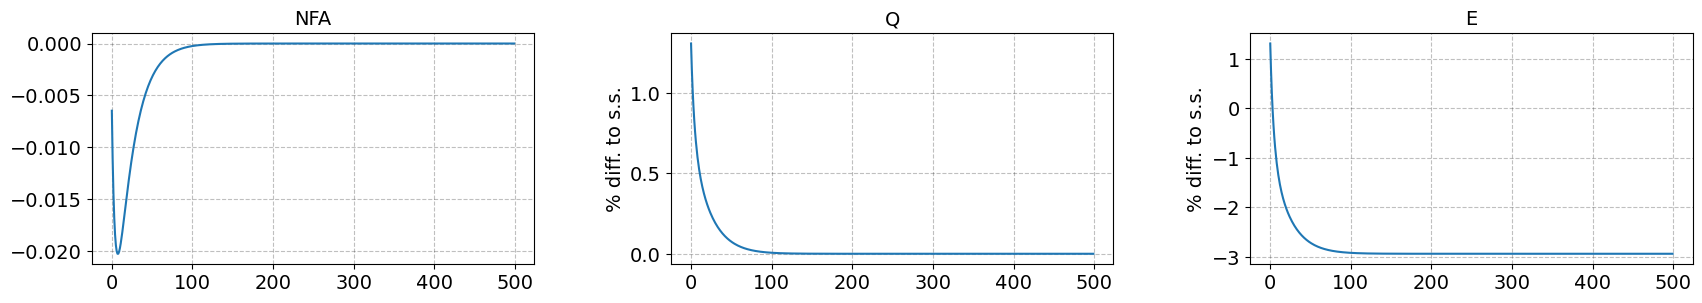

In [16]:
model.show_IRFs(['NFA','Q','E'],lvl_value=lvl_value,T_max=500,ncols=3,do_shocks=False,do_targets=False)